# Testando implementação em GPU do k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans). Código disponível na função `kMeansGPU`, localizada no arquivo `kMeans.py`.

## Imports e Variáveis Globais

In [270]:
import math
import numpy as np
import pandas as pd
import numba

# from kMeans import *
import kMeans as km

import importlib
importlib.reload(km)



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 5

K = 3
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [271]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])

dataset

,d0,d1,d2,d3,d4
0,4.048389,1.593326,8.240736,5.030112,9.384576
1,1.636828,4.083145,9.947502,7.980573,1.046110
2,4.479337,1.876560,9.289459,1.920568,7.773101
3,9.876947,2.044588,3.995566,9.324486,5.919449
4,1.046290,9.201426,5.384123,1.473972,8.256261
...,...,...,...,...,...
99995,2.785263,7.333326,2.276985,6.702603,8.871581
99996,3.510687,4.631156,8.616363,4.503742,3.616322
99997,7.006078,8.774329,5.512980,7.691853,2.751763
99998,1.362149,8.974555,9.746960,8.084413,5.107519


## K-Means (GPU)

In [272]:
# result = km.kMeansGPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

# result

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [273]:
# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
km.downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [274]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# // # Sobrescrevendo a coluna do dataset pelos indexes obtidos
# // dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Ignorando a coluna "class"
datasetTreated = dataset.drop(['class'], axis=1)
# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
datasetTreated = ((datasetTreated - datasetTreated.min()) / (datasetTreated.max() - datasetTreated.min())) * 9 + 1

# print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated}')
print(f'##### Dataset (tratado e normalizado, intervalo [1, 10]) #####\n{datasetTreated.to_string()}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


##### Dataset (tratado e normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid   petalLen  petalWid
0        3.00     6.625   1.610169     1.375
1        2.50     4.750   1.610169     1.375
2        2.00     5.500   1.457627  

## Rodando o K-Means

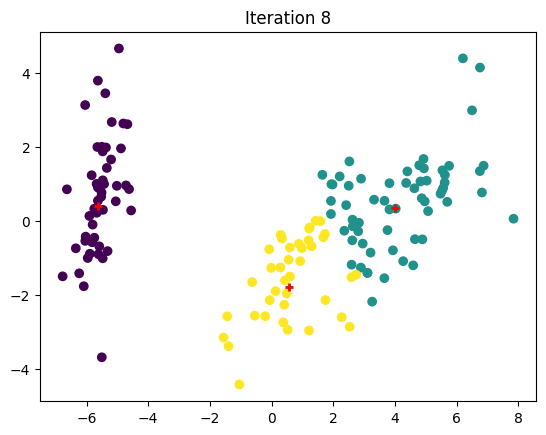

Iteration 8

Centroids:
          0         1         2         3
0  2.613660  6.143529  1.686990  1.494296
1  6.653880  4.714525  7.627264  7.778481
2  4.406264  3.218262  5.776541  5.361460

Distances:
[[ 0.63340803  9.70622249  6.84353366]
 [ 1.40533835  9.71936097  6.26343157]
 [ 0.9260384  10.06700369  6.74843026]
 [ 1.34286093  9.98068505  6.53407007]
 [ 0.87878518  9.88299936  7.09191534]
 [ 2.4000617   9.10677716  6.98113276]
 [ 0.91023606  9.94754929  6.8299681 ]
 [ 0.22336077  9.6434179   6.62852391]
 [ 2.23772135 10.32120126  6.67462028]
 [ 1.14034345  9.88756746  6.5117314 ]
 [ 1.68159287  9.53457884  7.05066216]
 [ 0.45817064  9.76644624  6.68148966]
 [ 1.52459918 10.07713518  6.58609722]
 [ 2.25295016 10.94702913  7.37241804]
 [ 3.20577401  9.94631125  7.9937908 ]
 [ 4.33983484  9.94636979  8.51975647]
 [ 2.38073305  9.49158217  7.32355426]
 [ 0.67257617  9.46302114  6.63209871]
 [ 2.51980674  9.00575234  6.88061483]
 [ 1.67365611  9.65921884  7.18802414]
 [ 1.20907023  9

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [275]:
# Rodando kMeansCPU
results = km.kMeansGPU(datasetTreated, K, MAX_ITERATIONS, printIter=True, plotResults=True, debug=True)

results

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.

Essa comparação, no entanto, não é tão simplória de se realizar. Não há como sabermos qual o mapeamento correto entre a classificação feita pelo k-means e as classes reais das instâncias do dataset. Isto é, não há como discernir se o `1` na coluna de classificação de centróides se refere a uma identificação de uma `Iris-versicolor` ao invés de uma `Iris-virginica`, por exemplo.

Por isso, temos que realizar o **maximum matching** atingido pelo resultado do k-means, para realizar uma avaliação justa de seu desempenho.

### Maximum Matching

Teremos que avaliar todas as possibilidades de *mapeamento centróide–classe* e considerar apenas aquela que gera o melhor resultado.

Para isso, é necessário calcular os acertos do resultado diversas vezes. Como há $ k! $ maneiras de se interpretar `K` centróides, isto irá gerar um **custo computacional de $ n \cdot k! $ operações de comparação** entre classificações.

Podemos reduzir este tempo de computação salvando e reaproveitando inteligentemente a quantidade de acertos de classificação computados para cada *mapeamento centróide–classe*.

Por exemplo, há **duas** interpretações dos `K` centróides que possuem um mapeamento `0 -> Iris-Setosa`. São eles: `[Iris-setosa, Iris-versicolor, Iris-virginica]` e `[Iris-setosa, Iris-virginica, Iris-versicolor]`. Ao contar os acertos da primeira destas permutações dos `K` centróides, vamos obter os acertos de linhas do resultado do k-means onde o centróide mais próximo é o de index `0`, e cuja interpreção atual é de este `0` indicar uma flor `Iris-Setosa`. Como iremos usar essa mesma interpretação para centróides de index `0` na próxima permutação, podemos pular essa contagem redundante utilizando o resultado obtido na contagem anterior.

Utilizando este método, conseguimos **reduzir o custo de computação** de acertos de classificação **para $ n^2 $ operações de comparação**!

In [276]:
from itertools import permutations

# print(f'result:\n{results}\n')
# print(f'dataset:\n{dataset}\n')
# print(f'classes:\n{classes}\n')

# Converting from numpy arrays to panda's dataframes, if needed
if results.__class__.__name__ != pd.DataFrame.__class__.__name__: results = pd.DataFrame(results)

hits, hitsPerClass, centroidClasses  = km.getClassificationHits(results, dataset, classes=classes, debug=False)

print(f'Hits: {hits}\nHits per class: {hitsPerClass}\nCentroid classes: {centroidClasses}\n')

Hits: 133
Hits per class: {'Iris-setosa': 50, 'Iris-versicolor': 36, 'Iris-virginica': 47}
Centroid classes: ('Iris-setosa', 'Iris-virginica', 'Iris-versicolor')



### Resultados

Rodando a função **`getClassificationHits()`** nos resultados do k-means, encontramos resultados bem esperados:

- Acertos totais entre **130–140**, de 150 classificações (**86,66–93,33%** de acerto)
- Acertos por classe:
  - `Iris-setosa`: quase sempre **50** de 50 (**100%**)
  - `Iris-versicolor`: **35–38** de 50 (**70–76%**)
  - `Iris-virginica`: **45–48** de 50 (**90–96%**)

Estes resultados são exatamente o que esperamos do dataset **Iris**, já que nele temos uma classe linearmente separável (`Iris-setosa`) e duas que NÃO são linearmente separáveis uma da outra (`Iris-versicolor` e `Iris-virginica`).



## Detalhes de Implementação

Um detalhe interessante de implementação foi a consideração de paralelizar ou não a parte de **cálculos dos logarítimos dos datapoints do dataset** na versão **GPU do K-Means**, realizada pela função `calcLogs()`.

Como esse cálculo é feito apenas uma vez na execução do algoritmo, poderia acabar sendo um caso de "otimização inútil". E exatamente isso foi o descoberto com alguns testes.

Esses testes parecem sugerir que a **implementação serial** (usando `numpy.log()`) **é mais rápida que a paralela** (usando `math.log()`) para os **quatro primeiros datasets** — em ordem crescente de instâncias, claro. Porém, a **versão paralela** começa a se tornar **mais rápida** no **quinto dataset (HHAR)** — **10,27% mais rápida**, para ser exato.

Como o tempo absoluto, até no maior dataset escolhido, ainda é de menos de 130ms, foi decidida manter a implementação paralela em uso, para demonstrar mais do uso da paralelização no trabalho, sem grande impacto na performance.

É importante notar, no entanto, que a comparação das implementações do cálculo de logarítimos aqui é de certa forma injusta! Isso pois, pelo fato da função `numpy.log()` não ser compatível com funções do **Numba** com `nopython=True, target='cuda'`, como é o caso aqui, somos obrigados a usar a função `math.log()` na GPU, que é menos otimizada. Essa limitação não ocorre ao se rodar o código serialmente na CPU.